The goal of this project is to create a model that can predict what type of common element of computer user interfaces an image is from a hand-written drawing (buttons, toggles, windows, etc.).

This is part 2 of that project, and covers pre-processing of the data. Part 1 can be found here.

In [18]:
# Import necessary packages
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn import svm
import cv2
import pandas as pd
import glob
import os
import pyarrow.parquet as pq
import seaborn as sns
from matplotlib import rcParams

Load in the data and convert it to a pandas dataframe.

In [2]:
table = pq.read_table('/Users/grahamsmith/Documents/SpringboardWork/UIsketch/UIsketch.parquet')

In [3]:
df = table.to_pandas()

In [16]:
# Double check that it looks like what we expect
df.head()

0    1    2    3    4    5    6    7    8    9  ...  150519  150520  \
0  255  255  255  255  255  255  255  255  255  255  ...     255     255   
1  255  255  255  255  255  255  255  255  255  255  ...     255     255   
2  255  255  255  255  255  255  255  255  255  255  ...     255     255   
3  255  255  255  255  255  255  255  255  255  255  ...     255     255   
4  255  255  255  255  255  255  255  255  255  255  ...     255     255   

   150521  150522  150523  150524  150525  150526  150527          label  
0     255     255     255     255     255     255     255  dropdown_menu  
1     255     255     255     255     255     255     255  dropdown_menu  
2     255     255     255     255     255     255     255  dropdown_menu  
3     255     255     255     255     255     255     255  dropdown_menu  
4     255     255     255     255     255     255     255  dropdown_menu  

[5 rows x 150529 columns]

Pre-processing is going to involve splitting the data into training and test sets, then building a baseline model. To perform stratified sampling, we take 80% of each class and for the training set and leave the remaining 20% to be the test set.

In [4]:
# Sample 80% of images within each class aka label.
train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.8))

In [5]:
# Get the indicies of the images not in the test set and assign those images to the test set.
testind = list(set(df.index) - set(train.index))
test = df.iloc[testind]

Split out the target feature (what we're trying to predict) from the rest.

In [6]:
x_train = train.loc[:, train.columns != 'label']
y_train = train['label']

x_test = test.loc[:, test.columns != 'label']
y_test = test['label']

K-Nearest-Neighbors is a fairly simple algorithm that predicts the class of an image based on the K most similar other images. We will use this as a baseline model with an arbitrary value of K.

In [7]:
# Fit the model
knn = KNeighborsClassifier(n_neighbors=3, weights= "distance")
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [15]:
# Predict on dataset which model has not seen before
result = knn.predict(x_test)
print(classification_report(y_test, result))

                        precision    recall  f1-score   support

                 alert       0.01      0.02      0.01       170
                button       0.58      0.32      0.41       231
                  card       0.55      0.11      0.19       194
      checkbox_checked       0.07      0.06      0.07       208
    checkbox_unchecked       0.51      0.25      0.33       206
                  chip       0.31      0.26      0.28       181
            data_table       0.36      0.13      0.20       178
         dropdown_menu       0.20      0.05      0.09       166
floating_action_button       0.67      0.08      0.14       184
             grid_list       0.00      0.00      0.00       175
                 image       0.79      0.24      0.37       224
                 label       0.58      0.39      0.47       211
                  menu       0.53      0.05      0.09       177
  radio_button_checked       0.02      0.02      0.02       175
radio_button_unchecked       0.63      

This initial model has a pretty abysmal mean precision (rate of true positives) of 39.6%, however, given that there are 18 classes, this is not a good method of measuring the quality of the model. Not only would picking randomly only yield an accuracy of 5.5%, making this 4x better than chance, but the variance between classes is extremely high.

10 classes have a precision greater than 50%, but 9 have a precision less than 20%, and 3 are actually worse than random chance. A good representation of this is shown in the following confusion matrix: 

In [13]:
# Get the actual predictions
y_pred = knn.predict(x_test)

ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (2).

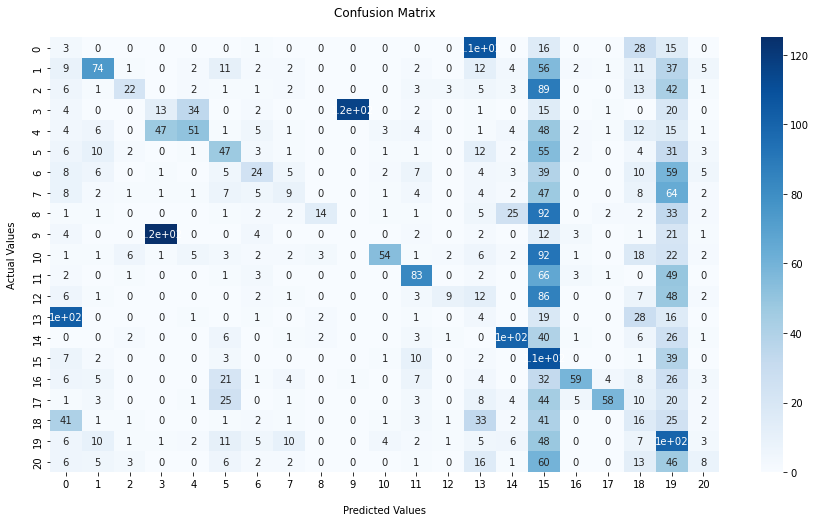

In [42]:
#Generate the confusion matrix

rcParams['figure.figsize'] = 15,8

cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

Moving on, there are several things we could do to improve on this foundation. Image augmentation through bootstrapping, etc. can help us with the classes that the model is worst at predicting. In particular: alert, checkbox_checked, radio_button_checked, grid_list and text_area.

In the next notebook, I will also be attempting some alternative more sophisticated algorithms, including but not limited to logit models, random forests, XGBoost and LGBM